In [1]:
## The primary issue with this model project is trying to predict future price movements while having
## our FTD data delayed by 15 days. 

## This folder and following code is going to attempt to create machine learning models to fill in the 
## missing gaps in data, and see if it can accurately predict FTD reporting in order to supplement our
## other models 

In [2]:
import pandas as pd

import glob

from pathlib import Path
import csv

import glob

In [4]:
# Machine-learning specific imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import model_from_json

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [5]:
## Load pickle for exports and imports of data  
import pickle 
def load_obj(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    
def save_obj(obj, path ):
    with open(path, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [6]:
## Test import code for the dataframe 

symbol = 'GME'
path = Path('../FilesExport_Complete_DFs_TI_noShift/'+symbol+'_TI_DF_no_shift.pkl')

data = load_obj(path)
import_df = data[symbol]
df = import_df.copy()
df

,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,...,ShortVolumeNSDQ,ShortExemptVolumeNSDQ,TotalVolumeNSDQ,ShortVolumeNYSE,ShortExemptVolumeNYSE,TotalVolumeNYSE,bollinger_signal,dema_signal,adl_signal,rsi_signal
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-02,26.629999,26.709999,25.590000,25.920000,20.004274,1840600.0,1840600.0,-0.71,-2.666,26.07333,...,117857.0,152.0,277309.0,11326.0,0.0,34626.0,0.692824,0.607545,-0.933333,0.180908
2016-02-03,26.110001,26.280001,24.750000,26.170000,20.197214,2223400.0,2223400.0,0.06,0.230,25.73333,...,212359.0,14.0,523222.0,9575.0,0.0,26571.0,0.714956,0.657842,-0.933333,0.251669
2016-02-04,26.059999,27.190001,25.379999,27.010000,20.845501,2000200.0,2000200.0,0.95,3.645,26.52667,...,156570.0,0.0,325811.0,17331.0,0.0,35015.0,0.591549,0.767042,-0.950000,0.666889
2016-02-05,27.010000,27.180000,26.430000,26.830000,20.706583,1545800.0,1545800.0,-0.18,-0.666,26.81333,...,115038.0,0.0,215572.0,6611.0,0.0,14960.0,0.617706,0.796823,-0.950000,0.532710
2016-02-08,26.549999,27.959999,26.500000,27.889999,21.524656,2944800.0,2944800.0,1.34,5.047,27.45000,...,257398.0,30.0,496626.0,27972.0,0.0,66574.0,0.491616,0.857710,-0.933333,0.795060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,152.000000,152.620000,140.000000,148.310000,148.310000,1613729.0,1613729.0,-3.69,-2.428,146.97667,...,227591.0,593.0,539793.0,56501.0,139.0,159382.0,0.951040,0.119788,0.716667,0.362483
2021-12-28,147.500000,157.410000,146.410000,146.460000,146.460000,1320374.0,1320374.0,-1.04,-0.705,150.09333,...,185176.0,0.0,424993.0,50426.0,0.0,126633.0,0.963783,0.165453,0.566667,0.321095
2021-12-29,147.850000,155.490000,142.140000,153.930000,153.930000,2029352.0,2029352.0,6.08,4.112,150.52000,...,280068.0,2383.0,627874.0,112580.0,798.0,295581.0,0.931590,0.930510,0.566667,0.421896


In [8]:
for col in df.columns:
    print(col)

open
high
low
close
adjClose
volume
unadjustedVolume
change
changePercent
vwap
changeOverTime
QUANTITY_FAILS
ShortVolumeNSDQ
ShortExemptVolumeNSDQ
TotalVolumeNSDQ
ShortVolumeNYSE
ShortExemptVolumeNYSE
TotalVolumeNYSE
bollinger_signal
dema_signal
adl_signal
rsi_signal


In [14]:
## Try neural net model - replace 'close' price with 'FTD'

## Takes one symbol and runs model data. 
## Call function for each individal symbol. No return data.  

def mean_squared_model(
    symbol,
    export_path,
    model_count = 5, ## Number of times model runs before saving the best one.
    validation_split_value=0.3,
    epochs_value=400,
    units1 = 8,
    units2 = 8,
    model_type = 'NN'
    ):
    
    import_path = Path('../FilesExport_Complete_DFs_TI_noShift/'+symbol+'_TI_DF_no_shift.pkl')
      
    data = load_obj(import_path)
    df = data[symbol]

    #data_dict[key] = df
        
    X = df.drop(columns={'QUANTITY_FAILS','adjClose'}).values
    y = df['QUANTITY_FAILS'].values
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)    
    
    num_of_inputs = 20
    num_of_outputs= 1
    layers = 1 ## Run the first model with one layer 

    for i in range(model_count):
        ## Create Neural Network 

        # Define the model - deep neural network with two layers
        nn = Sequential()

        # First hidden layer
        nn.add(Dense(units=units1, input_dim=num_of_inputs, activation="relu"))

        # Second hidden layer
        nn.add(Dense(units=units2, activation="relu"))

        # Output layer
        nn.add(Dense(units=num_of_outputs, activation="linear"))

        # Compile the model
        nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

        # Fit the model
        model = nn.fit(X, y, 
                          validation_split=validation_split_value, 
                          epochs=epochs_value, 
                          verbose=0)
            
        ## End of if/elif

        model_loss, model_accuracy = nn.evaluate(X, y, verbose=0)
        
        ## Save first model 
        if i == 0:
            model_accuracy_high= model_accuracy
            model_accuracy_low = model_accuracy
            symbol_accuracy_dict_high[symbol] = model_accuracy_high
            symbol_accuracy_dict_low[symbol] = model_accuracy_low
            # Save model as JSON
            nn_json = nn.to_json()

#             file_path = Path('../'+export_path+'/'+symbol+'_'+model_type+'_model_data.json')
#             with open(file_path, "w") as json_file:
#                 json_file.write(nn_json)

#             # Save weights
#             file_path = ('../Model_Data_high_loss/'+symbol+'_model_weights.h5')
#             nn.save_weights(file_path)
            
            file_path = Path(export_path+symbol+'_'+model_type+'_model_data.json')
            with open(file_path, "w") as json_file:
                json_file.write(nn_json)

            # Save weights
            file_path = (export_path+symbol+'_'+model_type+'_model_weights.h5')
            nn.save_weights(file_path)
        ## Rewrite saved model if accuracy is higher or lower 
        else:
            if model_accuracy > model_accuracy_high:
                ## Rewrite values 
                model_accuracy_high = model_accuracy
                symbol_accuracy_dict_high[symbol] = model_accuracy_high
                
                ## Rewrite saved files 
#                 nn_json = nn.to_json()

#                 file_path = Path('../Model_Data_high_loss/'+symbol+'_model_data.json')
#                 with open(file_path, "w") as json_file:
#                     json_file.write(nn_json)

#                 # Save weights
#                 file_path = ('../Model_Data_high_loss/'+symbol+'_model_weights.h5')
#                 nn.save_weights(file_path)
            elif model_accuracy < model_accuracy_low:
                ## Rewrite values 
                model_accuracy_low = model_accuracy
                symbol_accuracy_dict_low[symbol] = model_accuracy_low
                
                # Rewrite saved files 
                nn_json = nn.to_json()

                file_path = Path(export_path+symbol+'_'+model_type+'_model_data.json')
                with open(file_path, "w") as json_file:
                    json_file.write(nn_json)

                # Save weights
                file_path = (export_path+symbol+'_'+model_type+'_model_weights.h5')
                nn.save_weights(file_path)
    ## End of for loop 
    ## Return nothing 

In [15]:
## Create empty dicts for accuracy data 
symbol_accuracy_dict_low = {}
symbol_accuracy_dict_high = {}

test_symbol = 'GME'
mean_squared_model(test_symbol,export_path='../Model_Data/FTD_Model_Testing/')

In [22]:
## Create function to return dataframe based off symbol and if shift or no shift 
## Default to no shift 
def return_dataframe(symbol,shift=False):
    if shift == False:
        path = Path('../FilesExport_Complete_DFs_TI_noShift/'+symbol+'_TI_DF_no_shift.pkl')
        data_import = load_obj(path)
        df = data_import[symbol].copy()
    elif shift == True:
        path = Path('../FilesExport_Complete_DFs_TI_wShift/'+symbol+'_TI_DF_w_shift.pkl')
        data_import = load_obj(path)
        df = data_import[symbol].copy()
        
    return df 

In [30]:
## Load non-shifted data 
def get_no_shift_model(symbol,import_path,model_type):
    
    df = return_dataframe(symbol,shift=False)

    ## Set X and y data 
    X = df.drop(columns={'QUANTITY_FAILS','adjClose'}).values
    y = df['QUANTITY_FAILS'].values

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    # load json and create model
    file_path = Path(import_path+symbol+'_'+model_type+'_model_data.json')
    with open(file_path, "r") as json_file:
        model_json = json_file.read()
    loaded_model = model_from_json(model_json)

    # load weights into new model
    file_path = Path(import_path+symbol+'_'+model_type+'_model_weights.h5')
    loaded_model.load_weights(file_path)

    ## Compile loaded model and print mse score 
    loaded_model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])
    
    return loaded_model, df , X , y

In [31]:
# export_path+symbol+'_'+model_type+'_model_data.json'
# export_path+symbol+'_'+model_type+'_model_weights.h5'

import_path='../Model_Data/FTD_Model_Testing/'
model_type = 'NN'

loaded_model, df , X , y = get_no_shift_model(test_symbol,import_path,model_type)

In [32]:
score_ = loaded_model.evaluate(X, y, verbose=0)

In [33]:
score_

[66117832704.0, 66117832704.0]

<AxesSubplot:xlabel='Date'>

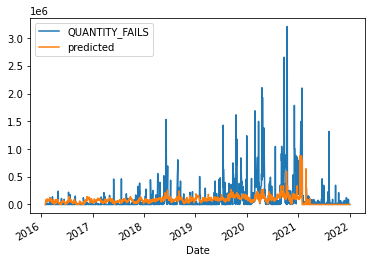

In [35]:
df['predicted'] = loaded_model.predict(X)
df_pred = df[['QUANTITY_FAILS','predicted']]

df_pred.plot()